In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import random

In [2]:
from sklearn.metrics import r2_score
from sklearn.impute import KNNImputer

In [3]:
heart = pd.read_csv('HeartData.csv')
heart.drop('Unnamed: 0',axis=1,inplace=True)

In [4]:
float_vec = np.vectorize(float)
nan_feature = []
for icol in heart.columns:
    L = np.sum(heart.loc[:,icol]=='?')
    if (L==0):
        heart.loc[:,icol] = float_vec(heart.loc[:,icol].values)
    else:
        nan_feature.append(icol)
        heart.loc[heart[icol]!='?',icol] = float_vec(heart.loc[heart[icol]!='?',icol].values)

In [5]:
heart.to_csv('HeartData.csv')

In [6]:
feature_mean   = {}
feature_median = {}

for icol in heart.columns:
    
    if icol not in nan_feature:
        continue
    L = heart.loc[heart[icol]!='?',icol].values 
    feature_mean[icol] = np.mean(L)
    feature_median[icol] = np.median(L)
    
clean_index = []
dirty_index = []

for ind in list(heart.index):
    if (np.sum(heart.loc[ind,:]=='?')==0):
        clean_index.append(ind)
    else:
        dirty_index.append(ind)

In [7]:
picked_cleanindex = random.sample(clean_index,int((1./3.)*len(clean_index)))
picked_cleanindex = list(set(picked_cleanindex))

In [8]:
clean_heart_mean   = heart.loc[picked_cleanindex,:].copy()
clean_heart_median = heart.loc[picked_cleanindex,:].copy()

In [9]:
clean_heart_mean.loc[:,nan_feature] = np.nan
clean_heart_median.loc[:,nan_feature] = np.nan

In [10]:
for ifeature in nan_feature:
    clean_heart_mean.loc[:,ifeature]   = feature_mean[ifeature]
    clean_heart_median.loc[:,ifeature] = feature_median[ifeature]

In [11]:
def MSE(y_true,y_pred):
    return (np.sum((y_true-y_pred)**2))/(y_true.shape[0]**2)

In [12]:
MSE_mean   = {}
MSE_median = {}

for ifeature in nan_feature:
    
    true_val        = heart.loc[picked_cleanindex,ifeature].values
    temp_mean_val   = clean_heart_mean.loc[:,ifeature].values
    temp_median_val = clean_heart_median.loc[:,ifeature].values
    
    MSE_mean[ifeature]   = MSE(true_val,temp_mean_val)
    MSE_median[ifeature] = MSE(true_val,temp_median_val)

In [ ]:
#np.sum(clean_heart_knn.loc[:,ifeature]=='?')

In [ ]:
#clean_heart_knn.shape

In [63]:
clean_heart_knn    = heart.copy()

for ifeature in nan_feature:
    if (np.sum(clean_heart_knn.loc[:,ifeature]=='?')!=0):
        bool_index = clean_heart_knn[ifeature]=='?'
        clean_heart_knn.loc[bool_index,ifeature] = np.nan
        
knn = KNNImputer()
knn.set_params(n_neighbors = 6)
knn_result = knn.fit_transform(clean_heart_knn)
knn_result_df = pd.DataFrame(data = knn_result, columns=heart.columns)

In [64]:
clean_heart_knn2 = heart.loc[picked_cleanindex,:].copy()
clean_heart_knn2.loc[:,nan_feature] = np.nan
data = knn.transform(clean_heart_knn2)
knn_result_df2 = pd.DataFrame(data = data, columns=heart.columns)

In [65]:
#imp_df = pd.DataFrame().from_dict(MSE_mean,orient='index')
#imp_df.columns = ['mean']
#imp_df['median'] = MSE_median.values()

In [66]:
MSE_knn = {}

for ifeature in nan_feature:
    
    true_val        = heart.loc[picked_cleanindex,ifeature].values
    temp_knn_val    = knn_result_df2.loc[:,ifeature].values
    
    MSE_knn[ifeature]   = MSE(true_val,temp_knn_val)

In [67]:
imp_df['knn_6'] = MSE_knn.values()

In [71]:
imp_df.reset_index(inplace=True)
imp_df

,index,mean,median,knn_1,knn_2,knn_3,knn_4,knn_5,knn_6
0,trestbps,2.943140,2.969901,1.492807,1.553056,1.911868,2.201089,2.228234,2.403598
1,chol,51.895640,37.372921,18.614325,32.951638,38.357537,59.004566,65.286416,66.370206
2,fbs,0.001236,0.001428,0.000408,0.000638,0.000726,0.000752,0.000788,0.000867
3,restecg,0.012234,0.020916,0.004081,0.005204,0.005657,0.007193,0.007734,0.008318
4,thalach,5.768701,5.540659,1.576676,1.989593,1.950152,2.494471,2.708817,2.850180
5,exang,0.002145,0.003061,0.000612,0.000689,0.000760,0.000963,0.000996,0.001083
6,oldpeak,0.014657,0.021987,0.006286,0.006040,0.006369,0.008199,0.008711,0.008657
7,slope,0.003768,0.004999,0.002551,0.001939,0.002324,0.002595,0.002706,0.002684
8,ca,0.008238,0.012448,0.003673,0.003035,0.004115,0.005076,0.005763,0.005938
9,thal,0.038744,0.057749,0.016631,0.014718,0.015599,0.019915,0.021361,0.021288


In [72]:
imp_df.to_csv('imputationDF.csv')

(0.0, 80.0)

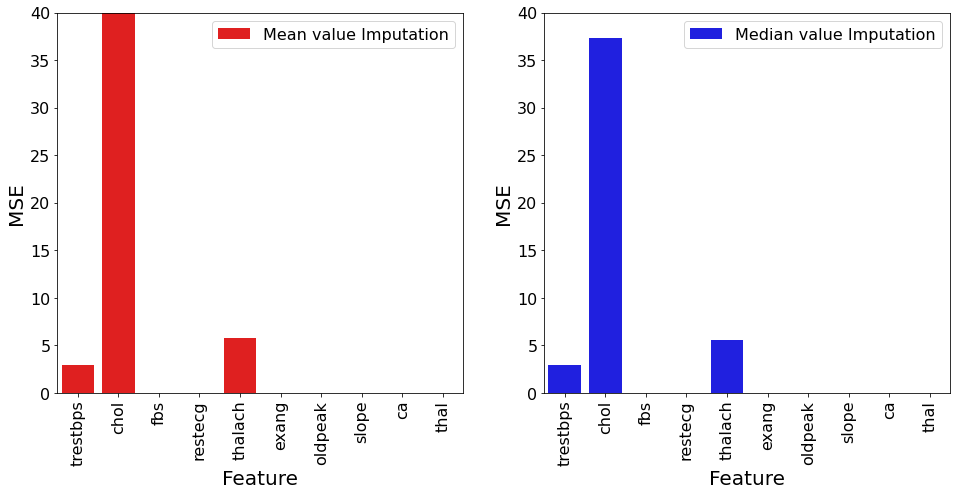

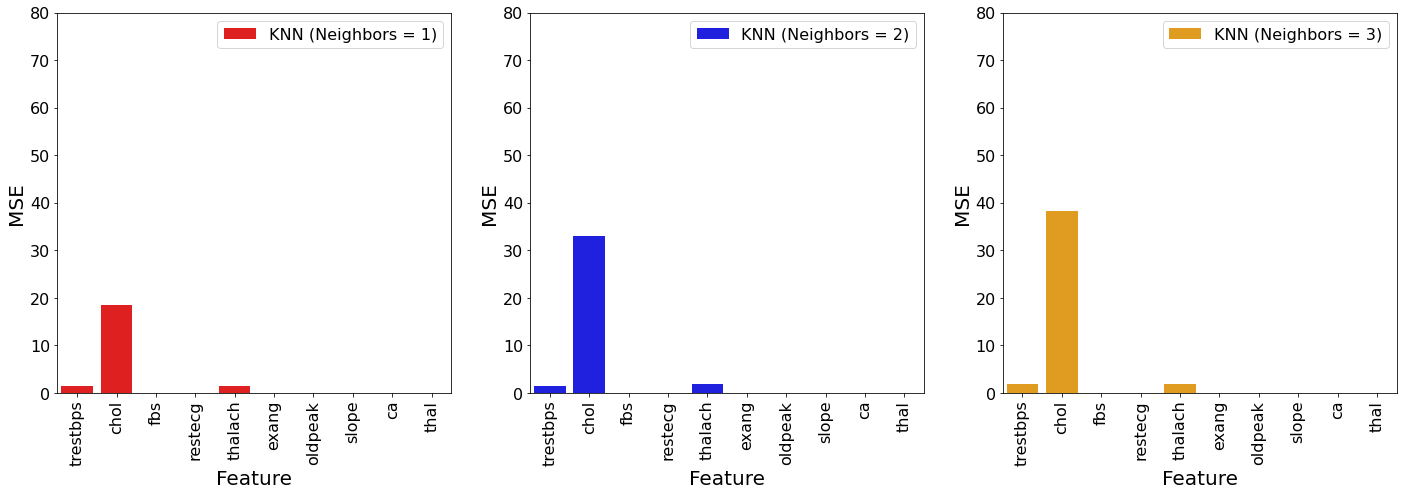

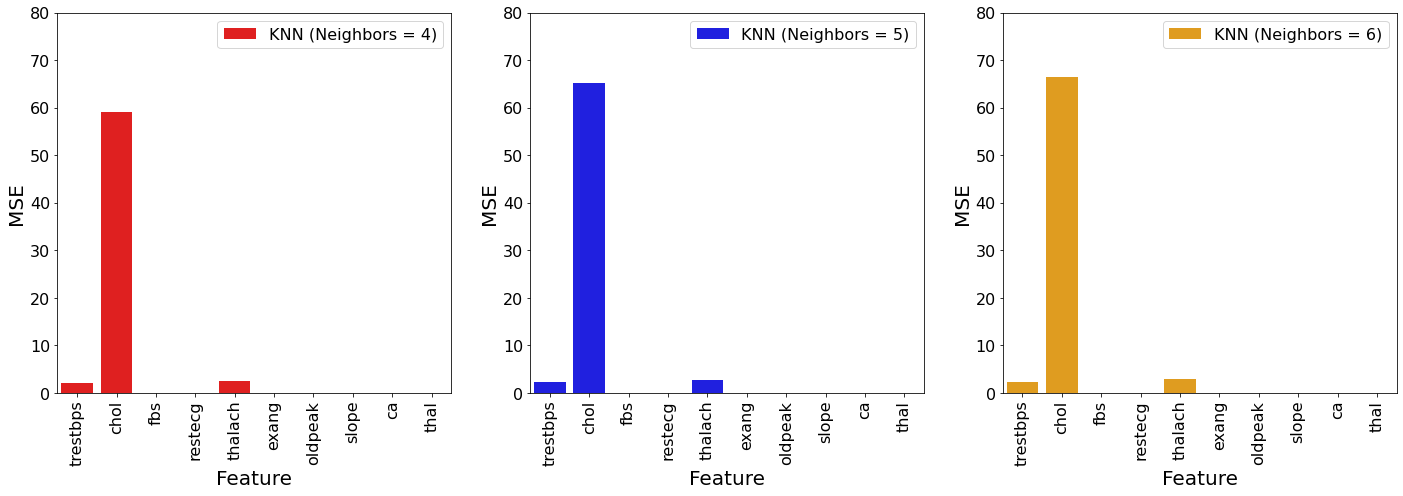

In [73]:
ig, axis = plt.subplots(1,2,figsize=(16,7))

sns.barplot(data = imp_df, x = 'index', y = 'mean', color = 'red', ax = axis[0], label = 'Mean value Imputation')
axis[0].set_xlabel('Feature', fontsize = 20)
axis[0].set_ylabel('MSE', fontsize = 20)
axis[0].set_xticklabels(axis[0].get_xticklabels(),fontsize=14, rotation = 90)
axis[0].tick_params(axis='both',labelsize=16)
axis[0].legend(fontsize = 16)
axis[0].set_ylim([0,40])

sns.barplot(data = imp_df, x = 'index', y = 'median', color = 'blue', ax = axis[1], label = 'Median value Imputation')
axis[1].set_xlabel('Feature', fontsize = 20)
axis[1].set_ylabel('MSE', fontsize = 20)
axis[1].set_xticklabels(axis[1].get_xticklabels(),fontsize=14, rotation = 90)
axis[1].tick_params(axis='both',labelsize=16)
axis[1].legend(fontsize = 16);
axis[1].set_ylim([0,40]);

fig, axis = plt.subplots(1,3,figsize=(24,7))

sns.barplot(data = imp_df, x = 'index', y = 'knn_1', color = 'red', ax = axis[0], label = 'KNN (Neighbors = 1)')
axis[0].set_xlabel('Feature', fontsize = 20)
axis[0].set_ylabel('MSE', fontsize = 20)
axis[0].set_xticklabels(axis[0].get_xticklabels(),fontsize=14, rotation = 90)
axis[0].tick_params(axis='both',labelsize=16)
axis[0].legend(fontsize = 16)

sns.barplot(data = imp_df, x = 'index', y = 'knn_2', color = 'blue', ax = axis[1], label = 'KNN (Neighbors = 2)')
axis[1].set_xlabel('Feature', fontsize = 20)
axis[1].set_ylabel('MSE', fontsize = 20)
axis[1].set_xticklabels(axis[1].get_xticklabels(),fontsize=14, rotation = 90)
axis[1].tick_params(axis='both',labelsize=16)
axis[1].legend(fontsize = 16)

sns.barplot(data = imp_df, x = 'index', y = 'knn_3', color = 'orange', ax = axis[2], label = 'KNN (Neighbors = 3)')
axis[2].set_xlabel('Feature', fontsize = 20)
axis[2].set_ylabel('MSE', fontsize = 20)
axis[2].set_xticklabels(axis[2].get_xticklabels(),fontsize=14, rotation = 90)
axis[2].tick_params(axis='both',labelsize=16)
axis[2].legend(fontsize = 16);

axis[0].set_ylim([0,80])
axis[1].set_ylim([0,80])
axis[2].set_ylim([0,80])

fig, axis = plt.subplots(1,3,figsize=(24,7))

sns.barplot(data = imp_df, x = 'index', y = 'knn_4', color = 'red', ax = axis[0], label = 'KNN (Neighbors = 4)')
axis[0].set_xlabel('Feature', fontsize = 20)
axis[0].set_ylabel('MSE', fontsize = 20)
axis[0].set_xticklabels(axis[0].get_xticklabels(),fontsize=14, rotation = 90)
axis[0].tick_params(axis='both',labelsize=16)
axis[0].legend(fontsize = 16)

sns.barplot(data = imp_df, x = 'index', y = 'knn_5', color = 'blue', ax = axis[1], label = 'KNN (Neighbors = 5)')
axis[1].set_xlabel('Feature', fontsize = 20)
axis[1].set_ylabel('MSE', fontsize = 20)
axis[1].set_xticklabels(axis[1].get_xticklabels(),fontsize=14, rotation = 90)
axis[1].tick_params(axis='both',labelsize=16)
axis[1].legend(fontsize = 16)

sns.barplot(data = imp_df, x = 'index', y = 'knn_6', color = 'orange', ax = axis[2], label = 'KNN (Neighbors = 6)')
axis[2].set_xlabel('Feature', fontsize = 20)
axis[2].set_ylabel('MSE', fontsize = 20)
axis[2].set_xticklabels(axis[2].get_xticklabels(),fontsize=14, rotation = 90)
axis[2].tick_params(axis='both',labelsize=16)
axis[2].legend(fontsize = 16);

axis[0].set_ylim([0,80])
axis[1].set_ylim([0,80])
axis[2].set_ylim([0,80])

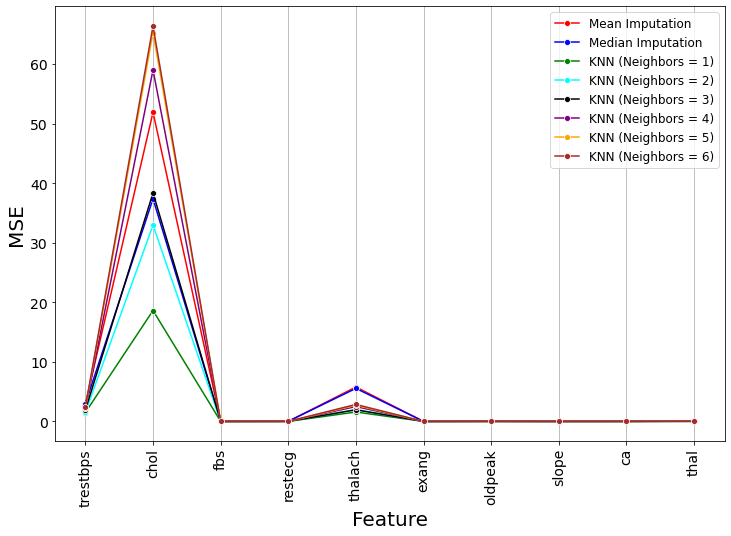

In [78]:
fig, axis = plt.subplots(1,1,figsize=(12,8))
sns.lineplot(data = imp_df, x = 'index', y = 'mean',   color = 'red',  marker = 'o', ax = axis, label = 'Mean Imputation' )
sns.lineplot(data = imp_df, x = 'index', y = 'median', color = 'blue', marker = 'o', ax = axis, label = 'Median Imputation' )
sns.lineplot(data = imp_df, x = 'index', y = 'knn_1', color = 'green', marker = 'o', ax = axis, label = 'KNN (Neighbors = 1)')
sns.lineplot(data = imp_df, x = 'index', y = 'knn_2', color = 'cyan', marker = 'o', ax = axis, label = 'KNN (Neighbors = 2)')
sns.lineplot(data = imp_df, x = 'index', y = 'knn_3', color = 'black', marker = 'o', ax = axis, label = 'KNN (Neighbors = 3)')
sns.lineplot(data = imp_df, x = 'index', y = 'knn_4', color = 'purple', marker = 'o', ax = axis, label = 'KNN (Neighbors = 4)')
sns.lineplot(data = imp_df, x = 'index', y = 'knn_5', color = 'orange', marker = 'o', ax = axis, label = 'KNN (Neighbors = 5)')
sns.lineplot(data = imp_df, x = 'index', y = 'knn_6', color = 'brown', marker = 'o', ax = axis, label = 'KNN (Neighbors = 6)')

axis.set_xlabel('Feature', fontsize = 20)
axis.set_ylabel('MSE', fontsize = 20)
axis.tick_params(axis='x',labelsize=14, labelrotation = 90)
axis.tick_params(axis='y',labelsize=14)
axis.legend(fontsize=12)
axis.grid(axis = 'x');

JUST DO A PRIMILINARY RANDOM FOREST AND LOGISTIC REGRESSION TO FIND IMPORTANT FEATURES

In [79]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

In [80]:
glm = LogisticRegression()
rfc = RandomForestClassifier()

In [81]:
glm.get_params()

{'C': 1.0,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 100,
 'multi_class': 'auto',
 'n_jobs': None,
 'penalty': 'l2',
 'random_state': None,
 'solver': 'lbfgs',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

In [ ]:
#?glm

In [ ]:
#?rfc

In [82]:
glm.set_params(solver = 'sag')

LogisticRegression(solver='sag')

In [83]:
from sklearn.model_selection import train_test_split

In [84]:
X = heart.loc[clean_index,:].drop(['num'],axis=1).copy()
Y = heart.loc[clean_index,'num']

In [85]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size=0.33, random_state=144, shuffle=True, stratify=Y) 

In [86]:
#fitting loggistic regression
glm.set_params(max_iter  = 1e5, C = 0.001)
glm.fit(X_train,Y_train)
r2_train = np.round(glm.score(X_train,Y_train),3)
r2_test  = np.round(glm.score(X_test,Y_test),3)
print('Trian score is :' + str(r2_train))
print('Test  score is :' + str(r2_test))

Trian score is :0.548
Test  score is :0.566


In [87]:
rfc.set_params(max_depth = 4)
rfc.fit(X_train,Y_train)
r2_train = np.round(rfc.score(X_train,Y_train),3)
r2_test  = np.round(rfc.score(X_test,Y_test),3)
print('Trian score is :' + str(r2_train))
print('Test  score is :' + str(r2_test))

Trian score is :0.789
Test  score is :0.576


In [88]:
from sklearn.feature_selection import SelectKBest

In [89]:
data = sorted(zip(X.columns,rfc.feature_importances_),key = lambda x : x[1],reverse=True)
df = pd.DataFrame(data = data)
df.columns = ['feature','importance']

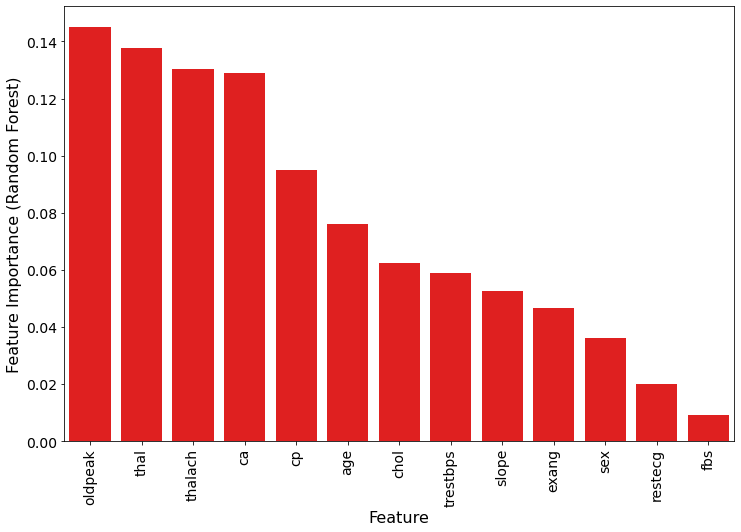

In [91]:
fig, axis = plt.subplots(1,1,figsize=(12,8))
sns.barplot(data = df, x='feature', y = 'importance', color = 'red', ax = axis)
axis.set_xlabel('Feature', fontsize = 16)
axis.set_ylabel('Feature Importance (Random Forest)', fontsize = 16)
axis.set_xticklabels(axis.get_xticklabels(),rotation = 90, fontsize = 14)
plt.yticks(fontsize=14);

In [92]:
from sklearn.preprocessing import StandardScaler

In [93]:
SC = StandardScaler()

In [94]:
X_SC = SC.fit_transform(X)

In [95]:
XSC_train, XSC_test, Y_train, Y_test = train_test_split(X_SC,Y, test_size=0.33, random_state=144, shuffle=True, stratify=Y) 